*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- [**pdpbox**](https://github.com/SauceCat/PDPbox)
- plotly
- scikit-learn
- scipy.stats
- [**shap**](https://github.com/slundberg/shap)
- xgboost


In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://github.com/skhabiri/PredictiveModeling-AppliedModeling-u2s3/tree/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

# Visualize and interpret partial dependence plots

## Overview

Partial dependence plots show the relationship between 1-2 individual features and the target — how predictions partially depend on the isolated features.

It's explained well by [PDPbox library documentation](https://pdpbox.readthedocs.io/en/latest/):

>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.


Let's also look at an [animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/pdp.html#examples):

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)


To demonstrate, we'll use a **Lending Club dataset**, to predict interest rates. (Like [this example](https://rrherr-project2-example.herokuapp.com/).)

In [3]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv')
history.sample(5)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
93780    41409452.0        NaN    18000.0      18000.0          18000.0   
115004  112149670.0        NaN     3200.0       3200.0           3200.0   
70411    78809793.0        NaN     7000.0       7000.0           7000.0   
82344    34903629.0        NaN    22400.0      22400.0          22400.0   
15981     7634756.0        NaN     5500.0       5500.0           5500.0   

              term int_rate  installment grade sub_grade  ...  \
93780    36 months    7.89%       563.15     A        A5  ...   
115004   36 months   12.62%       107.24     C        C1  ...   
70411    36 months    9.75%       225.05     B        B3  ...   
82344    60 months   16.49%       550.58     D        D3  ...   
15981    36 months   19.52%       203.06     D        D4  ...   

       orig_projected_additional_accrued_interest  \
93780                                         NaN   
115004                                        NaN   
70411                                         NaN   
82344                                         NaN   
15981                                         NaN   

       hardship_payoff_balance_amount hardship_last_payment_amount  \
93780                             NaN                          NaN   
115004                            NaN                          NaN   
70411                             NaN                          NaN   
82344                             NaN                          NaN   
15981                             NaN                          NaN   

        debt_settlement_flag debt_settlement_flag_date settlement_status  \
93780                      N                       NaN               NaN   
115004                     N                       NaN               NaN   
70411                      N                       NaN               NaN   
82344                      N                       NaN               NaN   
15981                      N                       NaN               NaN   

       settlement_date settlement_amount settlement_percentage settlement_term  
93780              NaN               NaN                   NaN             NaN  
115004             NaN               NaN                   NaN             NaN  
70411              NaN               NaN                   NaN             NaN  
82344              NaN               NaN                   NaN             NaN  
15981              NaN               NaN                   NaN             NaN  

[5 rows x 150 columns]

In [28]:
history.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128334 entries, 0 to 128333
Data columns (total 150 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          128334 non-null  float64
 1   member_id                                   0 non-null       float64
 2   loan_amnt                                   128334 non-null  float64
 3   funded_amnt                                 128334 non-null  float64
 4   funded_amnt_inv                             128334 non-null  float64
 5   term                                        128334 non-null  object 
 6   int_rate                                    128334 non-null  object 
 7   installment                                 128334 non-null  float64
 8   grade                                       128334 non-null  object 
 9   sub_grade                                   128334 non-null  object 


In [29]:
history['issue_d']

0         May-2017
1         Jan-2016
2         Dec-2013
3         Aug-2015
4         Feb-2014
            ...   
128329    Oct-2015
128330    May-2016
128331    Jul-2016
128332    Oct-2017
128333    Nov-2012
Name: issue_d, Length: 128334, dtype: object

In [30]:
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)
history['issue_d']

0        2017-05-01
1        2016-01-01
2        2013-12-01
3        2015-08-01
4        2014-02-01
            ...    
128329   2015-10-01
128330   2016-05-01
128331   2016-07-01
128332   2017-10-01
128333   2012-11-01
Name: issue_d, Length: 128334, dtype: datetime64[ns]

In [31]:
# Just use 36 month loans
history = history[history.term==' 36 months']

# Index & sort by issue date
history = history.set_index('issue_d').sort_index()
history.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
issue_d                                                                    
2007-07-01   90966.0        NaN     5000.0       5000.0           4150.0   
2007-07-01   94838.0        NaN     3000.0       3000.0           2550.0   
2007-07-01   92440.0        NaN     5000.0       5000.0           3100.0   
2007-07-01  112323.0        NaN     3500.0       3500.0           1125.0   
2007-08-01  122637.0        NaN     4000.0       4000.0           1550.0   

                  term int_rate  installment grade sub_grade  ...  \
issue_d                                                       ...   
2007-07-01   36 months    7.43%       155.38     A        A2  ...   
2007-07-01   36 months   10.28%        97.20     C        C1  ...   
2007-07-01   36 months    7.43%       155.38     A        A2  ...   
2007-07-01   36 months   10.28%       113.39     C        C1  ...   
2007-08-01   36 months    7.75%       124.89     A        A3  ...   

           orig_projected_additional_accrued_interest  \
issue_d                                                 
2007-07-01                                        NaN   
2007-07-01                                        NaN   
2007-07-01                                        NaN   
2007-07-01                                        NaN   
2007-08-01                                        NaN   

           hardship_payoff_balance_amount hardship_last_payment_amount  \
issue_d                                                                  
2007-07-01                            NaN                          NaN   
2007-07-01                            NaN                          NaN   
2007-07-01                            NaN                          NaN   
2007-07-01                            NaN                          NaN   
2007-08-01                            NaN                          NaN   

            debt_settlement_flag debt_settlement_flag_date settlement_status  \
issue_d                                                                        
2007-07-01                     N                       NaN               NaN   
2007-07-01                     N                       NaN               NaN   
2007-07-01                     N                       NaN               NaN   
2007-07-01                     N                       NaN               NaN   
2007-08-01                     N                       NaN               NaN   

           settlement_date settlement_amount settlement_percentage  \
issue_d                                                              
2007-07-01             NaN               NaN                   NaN   
2007-07-01             NaN               NaN                   NaN   
2007-07-01             NaN               NaN                   NaN   
2007-07-01             NaN               NaN                   NaN   
2007-08-01             NaN               NaN                   NaN   

           settlement_term  
issue_d                     
2007-07-01             NaN  
2007-07-01             NaN  
2007-07-01             NaN  
2007-07-01             NaN  
2007-08-01             NaN  

[5 rows x 149 columns]

### Clean data, engineer feature, & select subset of features

In [32]:
# Alter axes labels
history = history.rename(index=None, columns=                     
    {'annual_inc': 'Annual Income', 
     'fico_range_high': 'Credit Score', 
     'funded_amnt': 'Loan Amount', 
     'title': 'Loan Purpose'})

In [35]:
history['int_rate'][:10]

issue_d
2007-07-01      7.43%
2007-07-01     10.28%
2007-07-01      7.43%
2007-07-01     10.28%
2007-08-01      7.75%
2007-08-01     12.80%
2007-08-01      8.70%
2007-09-01     10.28%
2007-09-01      7.75%
2007-10-01     12.49%
Name: int_rate, dtype: object

In [36]:
# convert 'int_rate' objects to float values
history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)

In [38]:
history['Annual Income'][:10]

issue_d
2007-07-01    150000.0
2007-07-01    200000.0
2007-07-01     95000.0
2007-07-01     20000.0
2007-08-01     61800.0
2007-08-01     32000.0
2007-08-01    120000.0
2007-09-01    120000.0
2007-09-01     45000.0
2007-10-01     85000.0
Name: Annual Income, dtype: float64

In [39]:
# debt to income
history['dti']

issue_d
2007-07-01     0.00
2007-07-01     0.00
2007-07-01     3.83
2007-07-01     1.50
2007-08-01     3.46
              ...  
2019-03-01     1.61
2019-03-01     3.34
2019-03-01     6.88
2019-03-01     8.52
2019-03-01    19.60
Name: dti, Length: 102996, dtype: float64

In [40]:
history['Monthly Debts'] = history['Annual Income'] / 12 * history['dti'] / 100
history['Monthly Debts']

issue_d
2007-07-01       0.000000
2007-07-01       0.000000
2007-07-01     303.208333
2007-07-01      25.000000
2007-08-01     178.190000
                 ...     
2019-03-01     107.333333
2019-03-01     278.333333
2019-03-01    1100.800000
2019-03-01     362.100000
2019-03-01    1633.333333
Name: Monthly Debts, Length: 102996, dtype: float64

**_We start working with six features_**

In [41]:
columns = ['Annual Income', 
           'Credit Score', 
           'Loan Amount', 
           'Loan Purpose', 
           'Monthly Debts', 
           'Interest Rate']

history = history[columns]
history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102996 entries, 2007-07-01 to 2019-03-01
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Annual Income  102996 non-null  float64
 1   Credit Score   102996 non-null  float64
 2   Loan Amount    102996 non-null  float64
 3   Loan Purpose   101656 non-null  object 
 4   Monthly Debts  102968 non-null  float64
 5   Interest Rate  102996 non-null  float64
dtypes: float64(5), object(1)
memory usage: 5.5+ MB


In [46]:
history = history.dropna(axis=0, how='any', inplace=False)
history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101628 entries, 2007-07-01 to 2019-03-01
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Annual Income  101628 non-null  float64
 1   Credit Score   101628 non-null  float64
 2   Loan Amount    101628 non-null  float64
 3   Loan Purpose   101628 non-null  object 
 4   Monthly Debts  101628 non-null  float64
 5   Interest Rate  101628 non-null  float64
dtypes: float64(5), object(1)
memory usage: 5.4+ MB


**_Since the data is sorted based on the date (issue_d as index), we slects the last 10K samples as test, the second last 10K as validation set and the rest of the data as train_**

In [51]:
history[-1:]

Annual Income  Credit Score  Loan Amount           Loan Purpose  \
issue_d                                                                       
2019-03-01       100000.0         664.0       3600.0  Moving and relocation   

            Monthly Debts  Interest Rate  
issue_d                                   
2019-03-01    1633.333333           20.0

In [53]:
# Test on the last 10,000 loans,
# Validate on the 10,000 before that,
# Train on the rest

test = history[-10000:]
val = history[-20000:-10000]
train = history[:-20000]

### Split each dataset into X, y
**_Target label to be predicted is 'Interest Rate'_**

In [54]:
# Assign to X, y
target = 'Interest Rate'
features = history.columns.drop('Interest Rate')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

**_Let's look at the target distribution_**

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


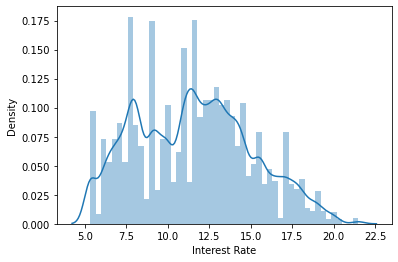

In [55]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

***The target has some right skew, but the tail is not too long***

In [56]:
history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101628 entries, 2007-07-01 to 2019-03-01
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Annual Income  101628 non-null  float64
 1   Credit Score   101628 non-null  float64
 2   Loan Amount    101628 non-null  float64
 3   Loan Purpose   101628 non-null  object 
 4   Monthly Debts  101628 non-null  float64
 5   Interest Rate  101628 non-null  float64
dtypes: float64(5), object(1)
memory usage: 5.4+ MB


***Other than "Loan Purpose" all other columns are numeric***

In [57]:
history["Loan Purpose"].value_counts()

Debt consolidation         48941
Credit card refinancing    20613
Home improvement            5730
Other                       5498
Major purchase              1961
                           ...  
Payoff and vacation            1
Easy pay loan                  1
The Wedding fund               1
Lending Club Refi              1
Dept Freedome                  1
Name: Loan Purpose, Length: 6697, dtype: int64

In [61]:
import category_encoders as ce
enc = ce.TargetEncoder(cols=['Loan Purpose']).fit(X_train, y_train)
enc_num = enc.transform(X_train)
print(type(enc_num))
enc_num["Loan Purpose"].value_counts()

<class 'pandas.core.frame.DataFrame'>


/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


11.642318    38419
10.215416    16419
11.562291     5788
11.190063     4159
12.966462     3824
             ...  
11.308401        2
9.747591         2
10.310506        2
14.294775        2
9.590413         2
Name: Loan Purpose, Length: 820, dtype: int64

***Target encoder needs to assign a number to each value of a categorical feature. The assigned number needs to be somehow related to the the target label in the "training set", so that in a row of observation the assigned number could be considered an input for that particular target label. The way this is achieved is we replace the categorical value with the average of the training y for that particular categorical value. In the case of a binary target it's probability of the training target label to be 1 for that categorical value. This is equivalent to groupby() for categorical feature and calculating the probability of target to be 1 for each of those categorical values. To generalize this, y can be binary or continuous. For each distinct element in categorical feature X you’re going to compute the average of the corresponding values in y. Then you’re going to replace each with the according mean.***

### Fit Linear Regression model

In [62]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.22422462337803906


/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Explaining Linear Regression

In [69]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features).sort_values()

Credit Score    -0.052736
Monthly Debts   -0.000021
Annual Income   -0.000003
Loan Amount      0.000018
Loan Purpose     1.000816
dtype: float64

In [66]:
X_train.head()

Annual Income  Credit Score  Loan Amount  \
issue_d                                                
2007-07-01       150000.0         779.0       5000.0   
2007-07-01       200000.0         679.0       3000.0   
2007-07-01        95000.0         774.0       5000.0   
2007-07-01        20000.0         684.0       3500.0   
2007-08-01        61800.0         749.0       4000.0   

                                        Loan Purpose  Monthly Debts  
issue_d                                                              
2007-07-01                               New kitchen       0.000000  
2007-07-01         Roofdeck for my new NYC apartment       0.000000  
2007-07-01                      Mortgage Pre-Payment     303.208333  
2007-07-01  Renting Apartment: Need security deposit      25.000000  
2007-08-01                                 Apartment     178.190000

<AxesSubplot:xlabel='Credit Score', ylabel='Interest Rate'>

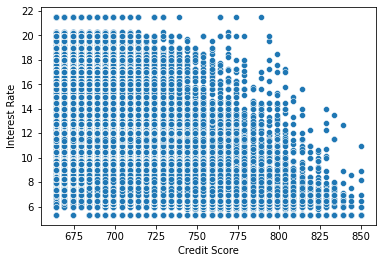

In [71]:
sns.scatterplot(data=X_train, y=y_train, x='Credit Score')

_It's hard to interpret the above scatter plot_

### Fit Gradient Boosting model


In [72]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.25057870813649097


### Explaining Gradient Boosting???

Linear models have coefficients, but trees do not.

Instead, to see the relationship between individual feature(s) and the target, we can use partial dependence plots.

## Follow Along


### Partial Dependence Plots with 1 feature

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)


In [74]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
plt.show()

In [75]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Annual Income'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Annual Income'>})

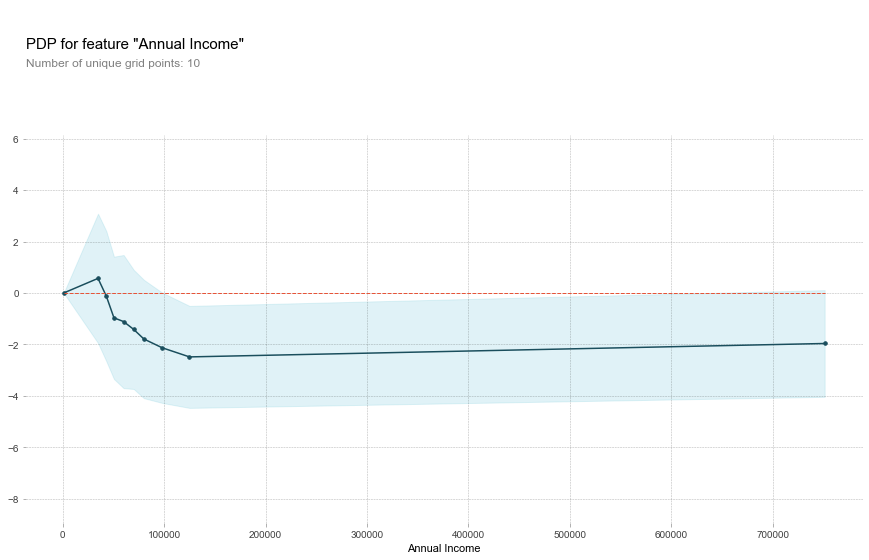

In [76]:
pdp_plot(isolated, feature_name=feature)

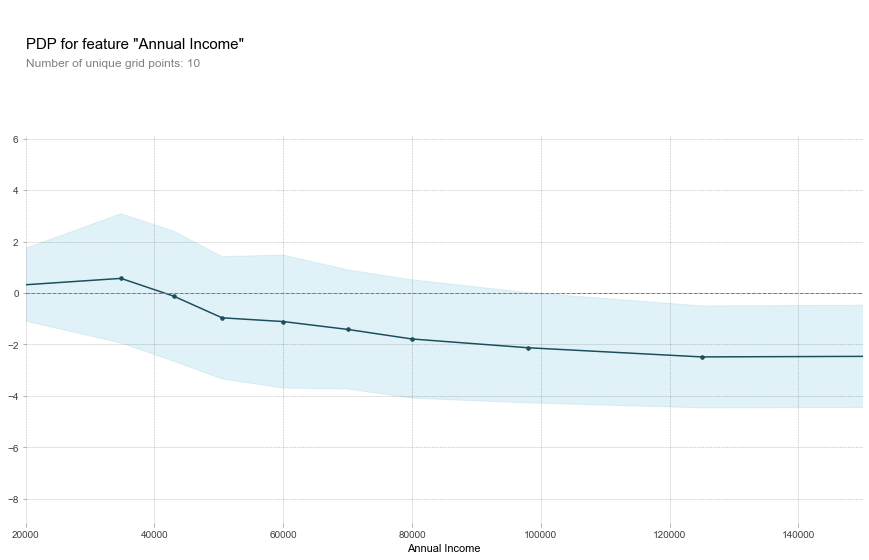

In [77]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((20000, 150000));

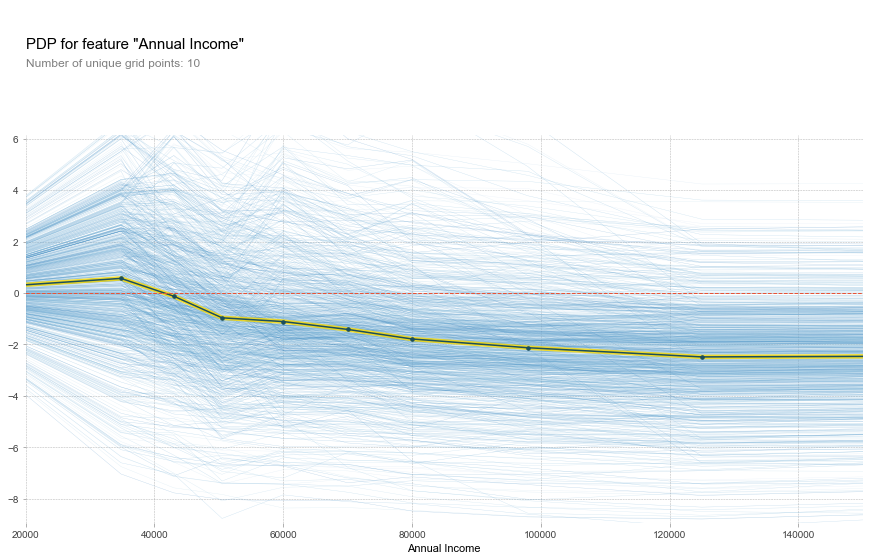

In [78]:
# frac_to_plot: How many lines to plot
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.1)

plt.xlim(20000,150000);

In [79]:
# Can use more grid points
isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature, 
    num_grid_points=50
)

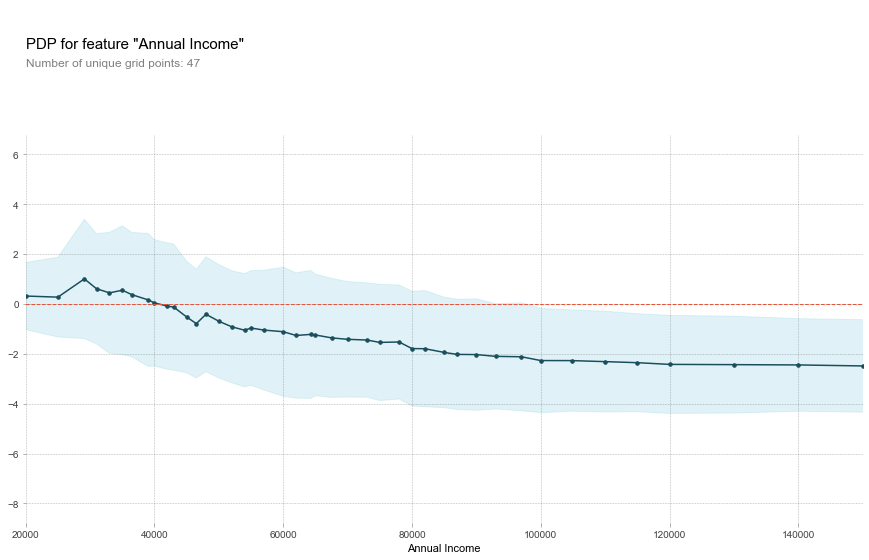

In [80]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((20000, 150000));

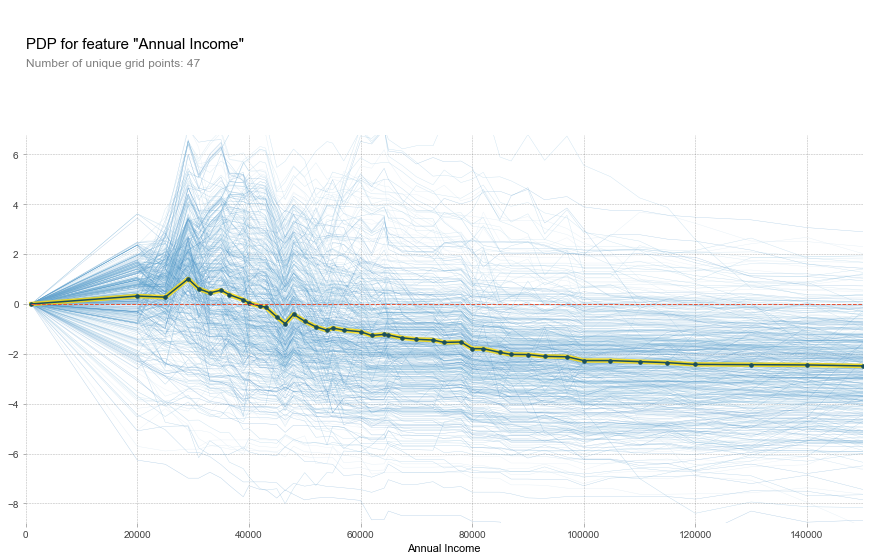

In [86]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=500)

plt.xlim(0,150000);

**_Each of the 50 sample values in the feature grid (num_grid_points) will replace the feature value of the X_val while preserving all other features with all their values in the X_val. frac_to_plot refers to the number of observations to be plotted in X_val_**

### Partial Dependence Plots with 2 features

See interactions!

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20 with some versions of matplotlib:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40


In [87]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Annual Income', 'Credit Score']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

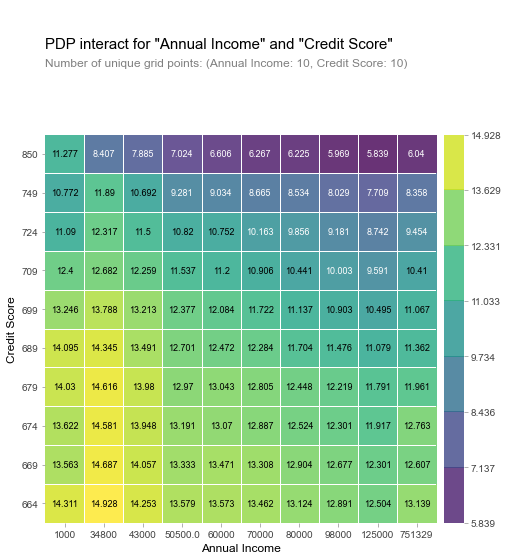

In [88]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### BONUS: 3D with Plotly!

Just for your future reference, here's how you can make it 3D! (Like [this example](https://rrherr-project2-example.herokuapp.com/).)

In [382]:
print(interaction.features)
# Get some of the available methods in interaction.pdp
[meth for meth in dir(interaction.pdp) if not meth.startswith('_')][-20:]

['sex', 'age']


['to_pickle',
 'to_records',
 'to_sql',
 'to_stata',
 'to_string',
 'to_timestamp',
 'to_xarray',
 'transform',
 'transpose',
 'truediv',
 'truncate',
 'tz_convert',
 'tz_localize',
 'unstack',
 'update',
 'value_counts',
 'values',
 'var',
 'where',
 'xs']

In [392]:
interaction.pdp[:]

sex    age     preds
0   1.0   0.42  0.485500
1   1.0  16.00  0.373122
2   1.0  21.00  0.342335
3   1.0  25.00  0.330679
4   1.0  28.00  0.342797
5   1.0  31.00  0.397307
6   1.0  36.00  0.308442
7   1.0  46.00  0.320183
8   1.0  80.00  0.289148
9   2.0   0.42  0.534662
10  2.0  16.00  0.516599
11  2.0  21.00  0.490750
12  2.0  25.00  0.474237
13  2.0  28.00  0.490452
14  2.0  31.00  0.504669
15  2.0  36.00  0.454601
16  2.0  46.00  0.425773
17  2.0  80.00  0.396694

In [394]:
interaction.pdp[:10:-2]

sex   age     preds
17  2.0  80.0  0.396694
15  2.0  36.0  0.454601
13  2.0  28.0  0.490452
11  2.0  21.0  0.490750

In [112]:
# First, make the 2D plot above. Then ...

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order
pdp

Annual Income   1000.0     34800.0    43000.0    50500.0    60000.0   \
Credit Score                                                           
850.0          11.276925   8.406872   7.885364   7.023724   6.605550   
749.0          10.772256  11.890440  10.691731   9.281055   9.033731   
724.0          11.089798  12.316732  11.500491  10.820369  10.751850   
709.0          12.400181  12.681756  12.259058  11.536571  11.200170   
699.0          13.246043  13.788149  13.213014  12.376525  12.083612   
689.0          14.094989  14.345033  13.491454  12.700768  12.471957   
679.0          14.030060  14.615670  13.979827  12.970486  13.042518   
674.0          13.621753  14.580919  13.947567  13.190585  13.069612   
669.0          13.563498  14.687138  14.057245  13.333296  13.470773   
664.0          14.310763  14.927646  14.252574  13.579004  13.572963   

Annual Income   70000.0    80000.0    98000.0    125000.0   751329.0  
Credit Score                                                          
850.0           6.266629   6.224547   5.968749   5.839097   6.040084  
749.0           8.664555   8.533667   8.029407   7.709332   8.358465  
724.0          10.163158   9.856141   9.181269   8.741926   9.454296  
709.0          10.906027  10.441317  10.002816   9.591278  10.410359  
699.0          11.722353  11.137074  10.903090  10.494962  11.067380  
689.0          12.283881  11.703503  11.476483  11.079331  11.362384  
679.0          12.805452  12.448201  12.218740  11.790907  11.961480  
674.0          12.886952  12.524303  12.301261  11.917036  12.762563  
669.0          13.308389  12.904493  12.677054  12.301342  12.606786  
664.0          13.462231  13.123998  12.891174  12.504457  13.139119

In [113]:
pdp = pdp.drop(columns=[1000.0, 751329.0])

In [115]:
target, features

('Interest Rate', ['Annual Income', 'Credit Score'])

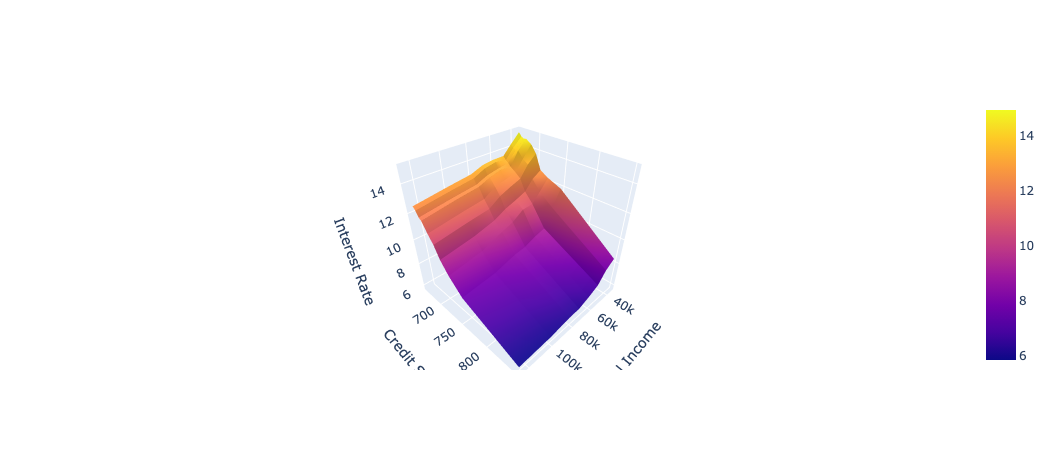

In [116]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

### BONUS: PDPs with categorical features

Just for your future reference, here's a bonus example to demonstrate partial dependence plots with categorical features.

1. I recommend you use Ordinal Encoder or Target Encoder, outside of a pipeline, to encode your data first. (If there is a natural ordering, then take the time to encode it that way, instead of random integers.) Then use the encoded data with pdpbox.
2. There's some extra work to get readable category names on your plot, instead of integer category codes.


Let's switch back to titanic dataset.

In [118]:
# Fit a model on Titanic data
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

df = sns.load_dataset('titanic')
df.age = df.age.fillna(value=df.age.median())
df = df.drop(columns='deck')
df = df.dropna(axis=0, how='any', inplace=False)
print(df.columns)

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive',
       'alone'],
      dtype='object')


In [119]:
# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [120]:
X_encoded.head()

pclass  sex   age  sibsp  parch     fare  embarked  class  who  adult_male  \
0       3    1  22.0      1      0   7.2500         1      1    1        True   
1       1    2  38.0      1      0  71.2833         2      2    2       False   
2       3    2  26.0      0      0   7.9250         1      1    2       False   
3       1    2  35.0      1      0  53.1000         1      2    2       False   
4       3    1  35.0      0      0   8.0500         1      1    1        True   

   embark_town  alone  
0            1  False  
1            2  False  
2            1   True  
3            1  False  
4            1   True

In [154]:
model.predict(X_encoded)[:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

pdp distribution is not bound with discrete classes that was predicted in classfier, i.e [1, 0]

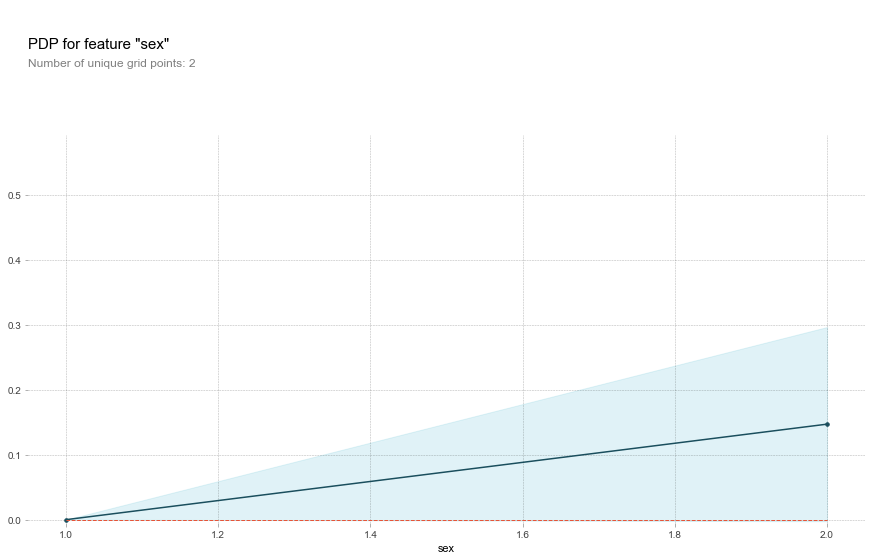

In [121]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [122]:
# Look at the encoder's mappings
encoder.mapping

[{'col': 'sex',
  'mapping': male      1
  female    2
  NaN      -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'embarked',
  'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'class',
  'mapping': Third     1
  First     2
  Second    3
  NaN      -2
  dtype: int64,
  'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False)},
 {'col': 'who',
  'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'embark_town',
  'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64,
  'data_type': dtype('O')}]

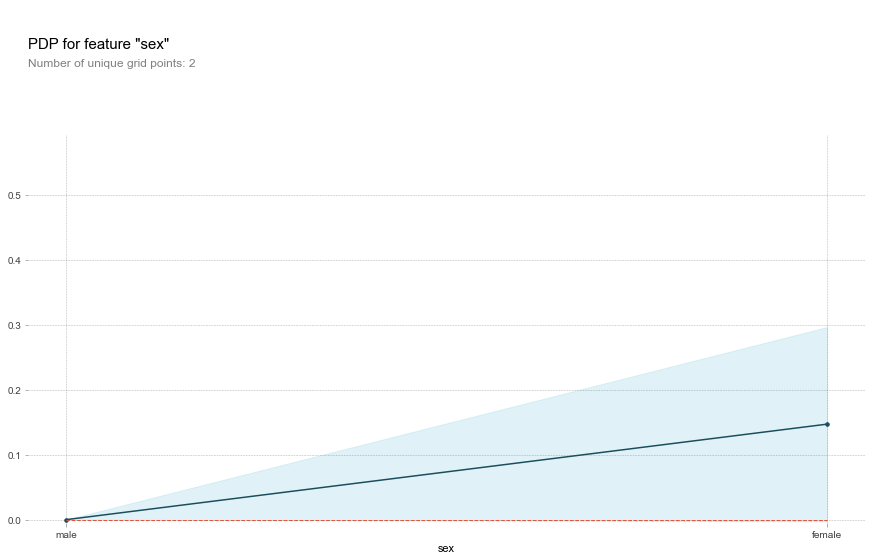

In [124]:
pdp.pdp_plot(pdp_dist, feature)

# Manually change the xticks labels
plt.xticks(ticks=[1, 2], labels=['male', 'female']);

In [126]:
encoder.mapping[0]

{'col': 'sex',
 'mapping': male      1
 female    2
 NaN      -2
 dtype: int64,
 'data_type': dtype('O')}

In [129]:
print(type(encoder.mapping[0]['mapping']))
encoder.mapping[0]['mapping']

<class 'pandas.core.series.Series'>


male      1
female    2
NaN      -2
dtype: int64

In [130]:
# Let's automate it

feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        # feature_mapping is a pd.Series
        feature_mapping = item['mapping']

# dropping NaN mapping        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()
category_names, category_codes

(['male', 'female'], [1, 2])

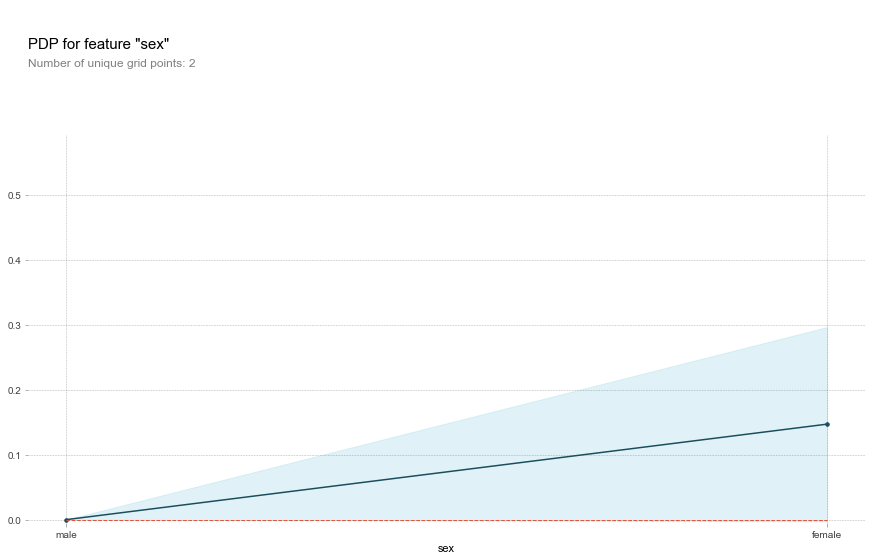

In [131]:
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(ticks=category_codes, labels=category_names);

### Multiple categorical features pdp plot

In [133]:
X_encoded.shape

(889, 12)

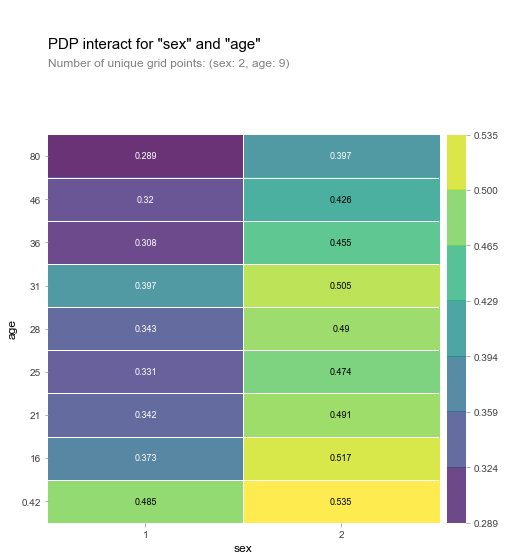

In [132]:
features = ['sex', 'age']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [134]:
interaction.pdp.head()

sex    age     preds
0  1.0   0.42  0.485500
1  1.0  16.00  0.373122
2  1.0  21.00  0.342335
3  1.0  25.00  0.330679
4  1.0  28.00  0.342797

In [148]:
interaction.pdp.pivot_table(values='preds', columns='sex',index='age')[::-1].head()

sex        1.0       2.0
age                     
80.0  0.289148  0.396694
46.0  0.320183  0.425773
36.0  0.308442  0.454601
31.0  0.397307  0.504669
28.0  0.342797  0.490452

In [137]:
dict(zip(category_codes, category_names))

{1: 'male', 2: 'female'}

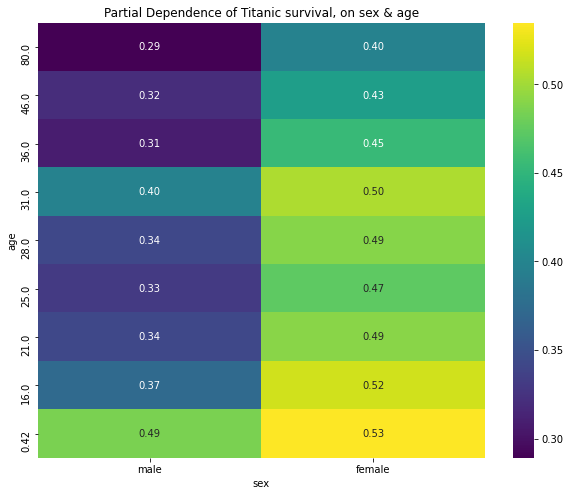

In [150]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns='sex',
    index='age'
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Titanic survival, on sex & age');

_pdp survival numbers are not limitted to discrete classes [1,0]_

# Explain individual predictions with shapley value plots

## Overview

We’ll use TreeExplainer from an awesome library called [SHAP](https://github.com/slundberg/shap), for “additive explanations” — we can explain individual predictions by seeing how the features add up!

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png" width="800" />

### Regression example

We're coming full circle, with the NYC Apartment Rent dataset! Remember this code you wrote for your first assignment?

```python
# Arrange X features matrix & y target vector
features = ['bedrooms', 'bathrooms']
target = 'price'
X = df[features]
y = df[target]

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

def predict(bedrooms, bathrooms):
    y_pred = model.predict([[bedrooms, bathrooms]])
    estimate = y_pred[0]
    bed_coef = model.coef_[0]
    bath_coef = model.coef_[1]
    
    # Format with $ and comma separators. No decimals.
    result = f'Rent for a {bedrooms}-bed, {bathrooms}-bath apartment in NYC is estimated at ${estimate:,.0f}.'
    explanation = f' In this model, each bedroom adds ${bed_coef:,.0f} & each bathroom adds ${bath_coef:,.0f}.'
    return result + explanation
```

Let’s do something similar, but with a tuned Random Forest and Shapley Values.

In [156]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

In [157]:
# Assign to X, y
features = ['bedrooms', 'bathrooms', 'longitude', 'latitude']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [158]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.2s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.4s finished


In [169]:
# 3 uniform distribution numbers between 1 and 1+5
uniform.rvs(loc=1, scale=5, size=3)

array([3.56094966, 3.02972734, 3.09884264])

In [159]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.6011150117432088, 'n_estimators': 201}
Cross-validation MAE 375.95637690332126


## Follow Along

#### [Dan Becker explains Shapley Values:](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?
>
>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 
>
>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [170]:
X_test.iloc[[0]]

bedrooms  bathrooms  longitude  latitude
0         3        1.5   -73.9425   40.7145

In [171]:
X_test.iloc[0]

bedrooms      3.0000
bathrooms     1.5000
longitude   -73.9425
latitude     40.7145
Name: 0, dtype: float64

In [172]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.
# double bracket returns two dimensional array
row = X_test.iloc[[0]]
row

bedrooms  bathrooms  longitude  latitude
0         3        1.5   -73.9425   40.7145

In [173]:
# What was the actual rent for this apartment?
y_test.iloc[[0]]

0    3000
Name: price, dtype: int64

In [174]:
# What does the model predict for this apartment?
model.predict(row)

array([3293.49306498])

In [175]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

**_For this local sample query those local values of latitude and bedrooms helped to increase the predicted value and those particular values of longitude and bathrooms helped to lower the predicted value by the amount shown_**

In [185]:
# expected_value is the mean of the predicted y, according to the X_train
# The difference in mean is due to bagging in Random Forest
explainer.expected_value, model.predict(X_train).mean()

(array([3575.72954331]), 3575.9567819757303)

In [198]:
row.values

array([[  3.    ,   1.5   , -73.9425,  40.7145]])

In [200]:
pd.Series(data=shap_values[0], index=zip(row.columns, row.values[0]))

(bedrooms, 3.0)          571.595298
(bathrooms, 1.5)         -45.094392
(longitude, -73.9425)   -963.949751
(latitude, 40.7145)      155.212367
dtype: float64

### Define the predict function

In [215]:
def predict(bedrooms, bathrooms, longitude, latitude):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[bedrooms, bathrooms, longitude, latitude]], 
        columns=['bedrooms', 'bathrooms', 'longitude', 'latitude']
    )

    # Get the model's prediction
    pred = model.predict(df)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)

    # Get series with shap values, feature names, & feature values
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'${pred:,.0f} estimated rent for this NYC apartment. \n\n'
    result += f'Starting from baseline of ${explainer.expected_value[0]:,.0f} \n'
    result += shaps.to_string()
    print(result)


    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

predict(3, 1.5, -73.9425, 40.7145)

$3,293 estimated rent for this NYC apartment. 

Starting from baseline of $3,576 
(bedrooms, 3.0)          571.595298
(bathrooms, 1.5)         -45.094392
(longitude, -73.9425)   -963.949751
(latitude, 40.7145)      155.212367


In [216]:
# What if it was a 2 bedroom?
predict(2, 1.5, -73.9425, 40.7145)

$3,280 estimated rent for this NYC apartment. 

Starting from baseline of $3,576 
(bedrooms, 2.0)           98.610829
(bathrooms, 1.5)         298.852890
(longitude, -73.9425)   -779.722262
(latitude, 40.7145)       86.996247


In [217]:
# What if it was a 1 bedroom?
predict(1, 1.5, -73.9425, 40.7145)

$2,990 estimated rent for this NYC apartment. 

Starting from baseline of $3,576 
(bedrooms, 1.0)         -116.980401
(bathrooms, 1.5)         358.867564
(longitude, -73.9425)   -915.405981
(latitude, 40.7145)       87.919580


* from 3 bedrooms to 1 bedroom, bedroom from a positive factor turns into a negative factor. 
* Going from 3 bedroom to 2 bedroom, 1,5 bathroom from being a negative factor becomes a positive factor

### Shaply: Classification example

Just for your future reference, here's a bonus example for a classification problem. This uses Lending Club data, historical and current. The goal: Predict if peer-to-peer loans are charged off or fully paid. Decide which loans to invest in.

In [218]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(DATA_PATH+'../data/lending-club/primaryMarketNotes_browseNotes_1-RETAIL.csv')

In [221]:
history.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0  109889419.0        NaN    20000.0      20000.0          20000.0   
1   68579794.0        NaN    21600.0      21600.0          21600.0   
2   10105952.0        NaN    25000.0      25000.0          24950.0   
3   57713137.0        NaN     5000.0       5000.0           5000.0   
4   11966074.0        NaN    11850.0      11850.0          11850.0   

         term int_rate  installment grade sub_grade  ...  \
0   36 months    9.44%       640.10     B        B1  ...   
1   36 months    9.80%       694.95     B        B3  ...   
2   36 months   17.57%       898.43     D        D2  ...   
3   36 months    6.89%       154.14     A        A3  ...   
4   36 months   14.16%       405.93     C        C2  ...   

  orig_projected_additional_accrued_interest hardship_payoff_balance_amount  \
0                                        NaN                            NaN   
1                                        NaN                            NaN   
2                                        NaN                            NaN   
3                                        NaN                            NaN   
4                                        NaN                            NaN   

  hardship_last_payment_amount  debt_settlement_flag  \
0                          NaN                     N   
1                          NaN                     N   
2                          NaN                     N   
3                          NaN                     N   
4                          NaN                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 150 columns]

In [240]:
# distribution of grade classes
a = history["grade"].value_counts(normalize=True)
b = current["grade"].value_counts(normalize=True)
pd.merge(left=a, right=b, how='outer', suffixes=('_history', '_current'), 
         sort=True, left_index=True, right_index=True)

grade_history  grade_current
A       0.196705       0.327586
B       0.324201       0.310345
C       0.314079       0.068966
D       0.165015       0.293103

In [236]:
pd.Timestamp.today()

Timestamp('2021-01-09 20:18:40.514591')

In [237]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
# There might be no secondary application. Hence error='coerce', then invalid parsing will be set as NaT.
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [ ]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [241]:
history["loan_status"].value_counts(normalize=True)

Fully Paid     0.824855
Charged Off    0.175145
Name: loan_status, dtype: float64

In [239]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [242]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 151)
y_train shape (88334,)
X_val shape (20000, 151)
y_val shape (20000,)
X_test shape (20000, 151)
y_test shape (20000,)


In [243]:
# Save the ids for later, so we can look up actual results,
# to compare with predicted results
train_id = X_train['id']
val_id = X_val['id']
test_id = X_test['id']

In [245]:
len(set(history.columns)), len(set(current.columns))

(152, 124)

**set operators:**
* | for union.
* & for intersection.
* – for difference
* ^ for symmetric difference

In [244]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [246]:
# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [253]:
X_train["emp_length"]

123050      8 years
84074     10+ years
98863     10+ years
111250      8 years
58143     10+ years
            ...    
87229      < 1 year
57613       3 years
17422        1 year
95127      < 1 year
67154     10+ years
Name: emp_length, Length: 88334, dtype: object

In [252]:
''' 
raw string does not convert \ and the next character as a new character. 
However still considers \ as a keyword for meta character in patern matching
'''
X_train["emp_length"].str.replace(r'\D','').astype(float)

123050     8.0
84074     10.0
98863     10.0
111250     8.0
58143     10.0
          ... 
87229      1.0
57613      3.0
17422      1.0
95127      1.0
67154     10.0
Name: emp_length, Length: 88334, dtype: float64

In [255]:
# covert every element of series to str first
X_train["title"].str.len()

123050    18.0
84074     23.0
98863     18.0
111250    18.0
58143     18.0
          ... 
87229     23.0
57613      5.0
17422     18.0
95127     18.0
67154     18.0
Name: title, Length: 88334, dtype: float64

In [259]:
X_train["title"].apply(lambda x: len(str(x)))

123050    18
84074     23
98863     18
111250    18
58143     18
          ..
87229     23
57613      5
17422     18
95127     18
67154     18
Name: title, Length: 88334, dtype: int64

In [260]:
X['sub_grade'].unique()

array(['B1', 'B3', 'D2', 'A3', 'C2', 'B4', 'C4', 'D4', 'B5', 'C1', 'A5',
       'A1', 'C5', 'B2', 'D1', 'D5', 'C3', 'A4', 'A2', 'D3'], dtype=object)

In [261]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        # col is a str
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    #pd.Series.str.strip(): Remove leading and trailing characters.
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    # na=value: fills the missing value
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to numbers
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    """
    We ran a model and found out which features have non zero feature importance:
    """
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Reset index
    # Whether to insert the index into a dataframe column or not
    X = X.reset_index(drop=True)
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [262]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

"""
eval_set : list, optional
    A list of (X, y) tuple pairs to use as validation sets, for which
    metrics will be computed.
"""
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.69237	validation_1-auc:0.68292
[1]	validation_0-auc:0.70191	validation_1-auc:0.69105
[2]	validation_0-auc:0.70925	validation_1-auc:0.69546
[3]	validation_0-auc:0.71459	validation_1-auc:0.69810
[4]	validation_0-auc:0.71864	validation_1-auc:0.70040
[5]	validation_0-auc:0.72193	validation_1-auc:0.70290
[6]	validation_0-auc:0.72553	validation_1-auc:0.70489
[7]	validation_0-auc:0.72874	validation_1-auc:0.70564
[8]	validation_0-auc:0.73156	validation_1-auc:0.70678
[9]	validation_0-auc:0.73473	validation_1-auc:0.70847
[10]	validation_0-auc:0.73768	validation_1-auc:0.70932
[11]	validation_0-auc:0.74092	validation_1-auc:0.70933
[12]	validation_0-auc:0.74534	validation_1-auc:0.70981
[13]	validation_0-auc:0.74865	validation_1-auc:0.71071
[14]	validation_0-auc:0.75171	validation_1-auc:0.71096
[15]	validation_0-auc:0.75358	validation_1-auc:0.71196
[16]	validation_0-auc:0.75657	validation_1-auc:0.71132
[17]	validation_0-auc:0.75982	validation_1-auc:0.71154
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

_validation_0 refers to the first eval set tuple (train)._

### explaining the test predictions

In [265]:
y_val.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [344]:
pd.DataFrame(data=model.predict_proba(X_val_processed), columns=model.classes_).head()

Charged Off  Fully Paid
0     0.175576    0.824424
1     0.202126    0.797874
2     0.236275    0.763725
3     0.130335    0.869665
4     0.018078    0.981922

_Let's consider Charged off as the positive class_

In [267]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.7011433111888041


#### Look at predictions vs actuals


In [269]:
df = pd.DataFrame({
    'id': test_id, 
    'pred_proba': y_pred_proba, 
    'status_group': y_test
})

# how='left': use only keys from left frame
df = df.merge(
     history[['id', 'issue_d', 'sub_grade', 'term', 'int_rate']], 
     how='left'
)

In [279]:
history[history.id==8626171.0][['id', 'issue_d', 'sub_grade', 'term', 'int_rate']]

id    issue_d sub_grade        term int_rate
25739  8626171.0 2013-11-01        B5   36 months   13.67%

In [270]:
df.head()

id  pred_proba status_group    issue_d sub_grade        term  \
0   8626171.0    0.917204   Fully Paid 2013-11-01        B5   36 months   
1  94031368.0    0.794576   Fully Paid 2016-11-01        B5   36 months   
2   5365832.0    0.894873   Fully Paid 2013-05-01        B2   36 months   
3  95806611.0    0.905223   Fully Paid 2017-01-01        A3   36 months   
4   3147498.0    0.968467   Fully Paid 2013-01-01        A3   36 months   

  int_rate  
0   13.67%  
1   11.49%  
2   11.14%  
3    7.24%  
4    7.62%

Creating boolean series representing y_true and y_pred for both classes

In [283]:
# y_true
fully_paid = df['status_group'] == 'Fully Paid' # Boolean series
charged_off = ~fully_paid

# y predictions
right = (fully_paid) == (df['pred_proba'] > 0.50) # Boolean series
wrong = ~right

In [286]:
right

0         True
1         True
2         True
3         True
4         True
         ...  
19995    False
19996     True
19997     True
19998     True
19999     True
Length: 20000, dtype: bool

#### Loan was fully paid, model's prediction was right


In [288]:
df[fully_paid & right].sample(n=10, random_state=1).sort_values(by='pred_proba', ascending=False)

id  pred_proba status_group    issue_d sub_grade        term  \
11977  117577487.0    0.954976   Fully Paid 2017-09-01        A4   36 months   
19881   43034190.0    0.953667   Fully Paid 2015-03-01        B1   36 months   
15604   13858000.0    0.948511   Fully Paid 2014-04-01        A4   36 months   
13224   73885365.0    0.946574   Fully Paid 2016-03-01        A1   36 months   
14227    1022317.0    0.943157   Fully Paid 2011-11-01        A4   60 months   
9712     2309900.0    0.861073   Fully Paid 2012-12-01        C1   36 months   
8247    10147231.0    0.827466   Fully Paid 2014-01-01        C2   36 months   
12751   90389379.0    0.805033   Fully Paid 2016-09-01        C1   36 months   
18808  136927746.0    0.768408   Fully Paid 2018-07-01        C3   60 months   
37      54533532.0    0.757412   Fully Paid 2015-07-01        C1   36 months   

      int_rate  
11977    7.35%  
19881    8.18%  
15604    7.90%  
13224    5.32%  
14227    7.90%  
9712    14.33%  
8247    14.47%  
12751   12.79%  
18808   15.02%  
37      12.29%

In [345]:
df[charged_off & right].sample(n=5, random_state=1).sort_values(by='pred_proba', ascending=False)

id  pred_proba status_group    issue_d sub_grade        term  \
17851  87474865.0    0.494683  Charged Off 2016-08-01        D5   60 months   
13297  16862799.0    0.486401  Charged Off 2014-05-01        C5   60 months   
12815  75311581.0    0.405693  Charged Off 2016-03-01        D4   60 months   
3587   59110989.0    0.328652  Charged Off 2015-08-01        D1   60 months   
11825  46783977.0    0.324141  Charged Off 2015-05-01        D4   60 months   

      int_rate  
17851   21.49%  
13297   14.99%  
12815   18.99%  
3587    15.61%  
11825   17.57%

In [314]:
# To explain the prediction for test observation with index #37, 
# first, get all of the features for that observation
row = X_test.iloc[[37]]
row

acc_open_past_24mths addr_state  all_util  annual_inc  annual_inc_joint  \
37                  10.0         NY       NaN     50012.0               NaN   

    avg_cur_bal  bc_open_to_buy  bc_util  collections_12_mths_ex_med  \
37        827.0         10011.0     27.5                         0.0   

    delinq_amnt  ...        term  title  title_NULL  tot_coll_amt  \
37          0.0  ...   36 months   18.0       False         469.0   

    tot_hi_cred_lim  total_acc  total_bal_il  total_bc_limit  total_cu_tl  \
37          57349.0       42.0           NaN         13800.0          NaN   

    total_rev_hi_lim  
37           43300.0  

[1 rows x 66 columns]

#### Explain individual predictions with shapley value plots

In [315]:
type(row)

pandas.core.frame.DataFrame

In [341]:
"""
link : "identity" or "logit"
    The transformation used when drawing the tick mark labels. Using logit will change log-odds numbers
    into probabilities. 
"""

import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)


In [325]:
model.predict(row_processed)

array(['Fully Paid'], dtype=object)

In [339]:
(y_train == 'Fully Paid').mean()

0.8248579256005615

In [322]:
explainer.expected_value

1.6142408

In [375]:
shap_values.shape

(1, 66)

the expected_value is calculated in the margin space, i.e. before the inverse link function is applied.
So for binary classification with logit link function, the expected value should be :
`np.mean(scipy.special.logit(predict_proba_preds))`

#### Make a function to explain predictions

Goal Output:

```
The model predicts this loan is Fully Paid, with 76% probability.
 
 
Top 3 reasons for prediction:
1. term is  36 months
2. installment = 233.5
 
 
Top counter-argument against prediction:
- acc_open_past_24mths = 10
- sub_grade is 3.1
 
<INSERT SHAPLEY VALUE FORCE PLOT HERE>
```

In [318]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(data=shap_values[0], index=zip(feature_names, feature_values))

In [320]:
shaps.sort_values(ascending=True)[:3]

(acc_open_past_24mths, 10.0)   -0.154592
(sub_grade, 3.1)               -0.126313
(addr_state, NY)               -0.115139
dtype: float32

In [321]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index
pros

Index([('term', ' 36 months'), ('installment', 233.48), ('total_acc', 42.0)], dtype='object')

In [351]:
print('Top 3 reasons for fully paid:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} is {feature_value}.')

print('\n')
print('Cons:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} is {feature_value}.')

Top 3 reasons for fully paid:
1. term is  36 months.
2. installment is 233.48.
3. total_acc is 42.0.


Cons:
1. acc_open_past_24mths is 10.0.
2. sub_grade is 3.1.
3. addr_state is NY.


In [357]:
dir(explainer)

['_Tree__dynamic_expected_value',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_main_effects',
 'assert_additivity',
 'data',
 'data_missing',
 'expected_value',
 'explain_row',
 'feature_names',
 'feature_perturbation',
 'link',
 'masker',
 'model',
 'model_output',
 'output_names',
 'shap_interaction_values',
 'shap_values',
 'supports_model_with_masker']

In [368]:
def explain(row_number):
    positive_class = 'Fully Paid'
    positive_class_index = 1

    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # Show prediction & probability
    print(f'The model predicts this loan is {pred}, with {pred_proba:.0f}% probability.')
    
    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)

    # Get top 3 "pros & cons" for fully paid
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # Show top 3 reason for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')

    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')

    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit' # For classification, this shows predicted probabilities
    )

explain(3094)

The model predicts this loan is Fully Paid, with 74% probability.


Top 3 reasons for prediction:
1. term is  36 months.
2. dti is 10.97.
3. total_acc is 45.0.


Top counter-argument against prediction:
- sub_grade is 4.2.


In [369]:
explain(37)

The model predicts this loan is Fully Paid, with 76% probability.


Top 3 reasons for prediction:
1. term is  36 months.
2. installment is 233.48.
3. total_acc is 42.0.


Top counter-argument against prediction:
- acc_open_past_24mths is 10.0.


In [373]:
dir(shap_values)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

#### Look at more examples

You can choose an example from each quadrant of the confusion matrix, and get an explanation for the model's prediction.

#### Loan was charged off, model's prediction was right


In [376]:
df[charged_off & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba status_group    issue_d sub_grade        term  \
1990   88047355.0    0.277427  Charged Off 2016-08-01        D5   60 months   
11825  46783977.0    0.324141  Charged Off 2015-05-01        D4   60 months   
12802  63180797.0    0.325553  Charged Off 2015-11-01        D2   60 months   
3587   59110989.0    0.328652  Charged Off 2015-08-01        D1   60 months   
12815  75311581.0    0.405693  Charged Off 2016-03-01        D4   60 months   
14498  46835159.0    0.417720  Charged Off 2015-05-01        C5   60 months   
13297  16862799.0    0.486401  Charged Off 2014-05-01        C5   60 months   
8160   38526612.0    0.492225  Charged Off 2015-01-01        D2   36 months   
6268   98815734.0    0.493722  Charged Off 2017-02-01        C5   60 months   
17851  87474865.0    0.494683  Charged Off 2016-08-01        D5   60 months   

      int_rate  
1990    21.49%  
11825   17.57%  
12802   16.55%  
3587    15.61%  
12815   18.99%  
14498   14.65%  
13297   14.99%  
8160    15.99%  
6268    15.99%  
17851   21.49%

In [377]:
explain(8160)

The model predicts this loan is Charged Off, with 51% probability.


Top 3 reasons for prediction:
1. mo_sin_old_rev_tl_op is 12.0.
2. sub_grade is 4.2.
3. mo_sin_old_il_acct is 169.0.


Top counter-argument against prediction:
- installment is 140.61.


#### Loan was fully paid, model's prediction was wrong


In [378]:
df[fully_paid & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba status_group    issue_d sub_grade        term  \
10397  120601209.0    0.299469   Fully Paid 2017-10-01        D2   60 months   
3804    83737389.0    0.388015   Fully Paid 2016-06-01        D5   36 months   
11353  120062859.0    0.436761   Fully Paid 2017-09-01        C2   60 months   
2173    19035015.0    0.451968   Fully Paid 2014-06-01        D3   60 months   
11763   20789451.0    0.453101   Fully Paid 2014-07-01        D3   60 months   
13478   42294722.0    0.462483   Fully Paid 2015-03-01        D5   60 months   
1634     1508228.0    0.473771   Fully Paid 2012-09-01        D4   60 months   
6308   133762262.0    0.494988   Fully Paid 2018-05-01        D4   60 months   
10333   88383038.0    0.497047   Fully Paid 2016-09-01        D5   60 months   
14900  116869072.0    0.497952   Fully Paid 2017-09-01        D5   36 months   

      int_rate  
10397   18.06%  
3804    21.49%  
11353   13.59%  
2173    16.99%  
11763   16.99%  
13478   17.86%  
1634    19.05%  
6308    20.39%  
10333   21.49%  
14900   21.45%

In [379]:
explain(2173)

The model predicts this loan is Charged Off, with 55% probability.


Top 3 reasons for prediction:
1. sub_grade is 4.3.
2. term is  60 months.
3. dti is 30.85.


Top counter-argument against prediction:
- issue_d_year is 2014.


#### Loan was charged off, model's prediction was wrong


In [380]:
df[charged_off & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba status_group    issue_d sub_grade        term  \
3217   117019810.0    0.619708  Charged Off 2017-08-01        C4   36 months   
3539    35948592.0    0.625273  Charged Off 2014-11-01        D1   60 months   
13948   87004569.0    0.648816  Charged Off 2016-08-01        C5   60 months   
13823  116809148.0    0.684329  Charged Off 2017-08-01        D2   60 months   
650     71016217.0    0.746316  Charged Off 2016-02-01        B3   36 months   
15436   48181401.0    0.782803  Charged Off 2015-05-01        C4   60 months   
19306   65945371.0    0.787890  Charged Off 2015-12-01        C3   60 months   
9698    17733706.0    0.823966  Charged Off 2014-06-01        B5   36 months   
12119   55200519.0    0.844712  Charged Off 2015-07-01        B3   60 months   
18432   67476268.0    0.887326  Charged Off 2015-12-01        B3   36 months   

      int_rate  
3217    15.05%  
3539    15.59%  
13948   15.59%  
13823   18.06%  
650      9.75%  
15436   13.99%  
19306   13.18%  
9698    12.49%  
12119    9.99%  
18432    9.76%

In [381]:
explain(650)

The model predicts this loan is Fully Paid, with 75% probability.


Top 3 reasons for prediction:
1. sub_grade is 2.3.
2. term is  36 months.
3. installment is 160.75.


Top counter-argument against prediction:
- dti is 24.62.


## References

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

## Recap

You learned about three types of model explanations during the past 1.5 lessons:

#### 1. Global model explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### 3. Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

## Challenge

Complete these tasks for your project, and document your work.

- Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- Make at least 1 partial dependence plot to explain your model.
- Make at least 1 Shapley force plot to explain an individual prediction.
- **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).